In [1]:
import numpy as np
from get_border_cases import get_border_cases
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
n = 17
N = n - 1
inner_n = n - 2
border_cases = get_border_cases(N)
params = np.ones(inner_n ** 2)

In [3]:
'''
    Computes the value of a game.
    game is 2x2 matrix.
'''
def get_value(game):
    return (game[0, 0] * game[1, 1] - game[0, 1] * game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 1.
'''
def get_p1(game):
    return (game[1, 1] - game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 2.
'''
def get_q1(game):
    return (game[1, 1] - game[0, 1]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Converts global index to inner index.
    index - index to convert.
    inner_n - inner dimension (without borders).
    global_n - outer dimension (with borders).
'''
def inner_n_to_global_N(index, inner_n, global_n):
    row = index // inner_n
    col = index % inner_n
    global_index = (row + 1) * global_n + (col + 1)
    return global_index

def global_N_to_inner_n(index, inner_n, global_n):
    row = index // global_n
    col = index % global_n

    if row < 1 or col < 1 or row > global_n - 2 or col > global_n - 2:
        raise ValueError("Index should match an inner node.")
    inner_index = (row - 1) * inner_n + (col - 1)
    return inner_index

'''
    Checks if a game matrix has saddles.
'''
def check_for_saddle(game):
    maximin = np.max(np.min(game, axis=1))
    minimax = np.min(np.max(game, axis=0))
    res = 'N'
    if np.isclose(maximin, minimax, rtol=1e-8, atol=1e-8):
        res = maximin
        index = next(i for i, _ in enumerate(game.flatten()) if np.isclose(_, res, rtol=1e-8, atol=1e-8)) 
        return res, (1 - index // 2, 1 - index % 2) # fixed
    return 'N'
    
def get_game(index, w):
    game = np.zeros((2, 2))
    game[0, 0] = compute_a11(index, w)
    game[0, 1] = compute_a12(index, w)
    game[1, 0] = compute_a21(index, w)
    game[1, 1] = compute_a22(index, w)
    return game

# Up
def compute_a11(index, w):
    if (index - n) in border_cases:
        a11 = 1
    else:
        a11 = w[global_N_to_inner_n(index - n, inner_n, n)] + 1
    return a11
    
# Down
def compute_a21(index, w):
    if (index + n) in border_cases:
        a12 = 1
    else:
        a12 = w[global_N_to_inner_n(index + n, inner_n, n)] + 1
    return a12

# Right
def compute_a12(index, w):
    if (index + 1) in border_cases:
        a21 = 1
    else:
        a21 = w[global_N_to_inner_n(index + 1, inner_n, n)] + 1
    return a21

# Left
def compute_a22(index, w):
    if (index - 1) in border_cases:
        a22 = 1
    else:
        a22 = w[global_N_to_inner_n(index - 1, inner_n, n)] + 1
    return a22
    

'''
    Number of values in w should match number of equations.
'''
def prepare_equations(w):
    eqs = np.zeros(len(w))
    p1s = []
    q1s = []
    for i in range(len(w)):
        index = inner_n_to_global_N(i, inner_n, n)
        game_mx = get_game(index, w)
        saddle = check_for_saddle(game_mx)
        if saddle == "N":
            v = get_value(game_mx)
            p1 = get_p1(game_mx)
            q1 = get_q1(game_mx)
        else:
            v, (p1, q1) = saddle

        p1s.append(p1)
        q1s.append(q1)
        eqs[i] = w[i] - v

    return tuple(eqs)

In [7]:
# first launch first line and then uncomment others

from scipy.optimize import fsolve


starting_params = np.random.random(inner_n ** 2) * (inner_n - 1) ** 2 * 0.68
#starting_params = starting_params.reshape(inner_n, inner_n)
#starting_params[1:-1, 1:-1] = np.array(vs).reshape(inner_n - 2, inner_n - 2)
#starting_params = starting_params.flatten()
#starting_params = np.ones(inner_n ** 2) * 3
w_new, _, _, message  = fsolve(prepare_equations, tuple(starting_params), full_output=True)
print(message)

The solution converged.


In [8]:
(inner_n - 1) ** 2 * 0.68, w_new.reshape(inner_n, inner_n)[inner_n // 2, inner_n // 2]

(133.28, 122.76321911506575)

In [9]:
p1s = []
q1s = []
vs = []
for i in range(inner_n ** 2):
    index = inner_n_to_global_N(i, inner_n, n)
    game_mx = get_game(index, w_new)
    saddle = check_for_saddle(game_mx)

    #print(f"index = {index}")
    #print(f"game_mx:\n {game_mx}")
    #print(f"saddle = {saddle}")
    if saddle == "N":
        v = get_value(game_mx)
        p1 = get_p1(game_mx)
        q1 = get_q1(game_mx)
        #print(f"p1 form N: {p1}")
    else:
        v, (p1, q1) = saddle

    #print(f"v = {v}")
    #print(f"p1 = {p1}")
    #print(f"q1 = {q1}")
    p1s.append(p1)
    q1s.append(q1)
    vs.append(v)

In [10]:
np.save("../data/strategy_pvp_center_optimal.npy", p1s)
np.save("../data/strategy_pvp_border_optimal.npy", q1s)

Text(0.5, 1.0, 'Mean absorption time')

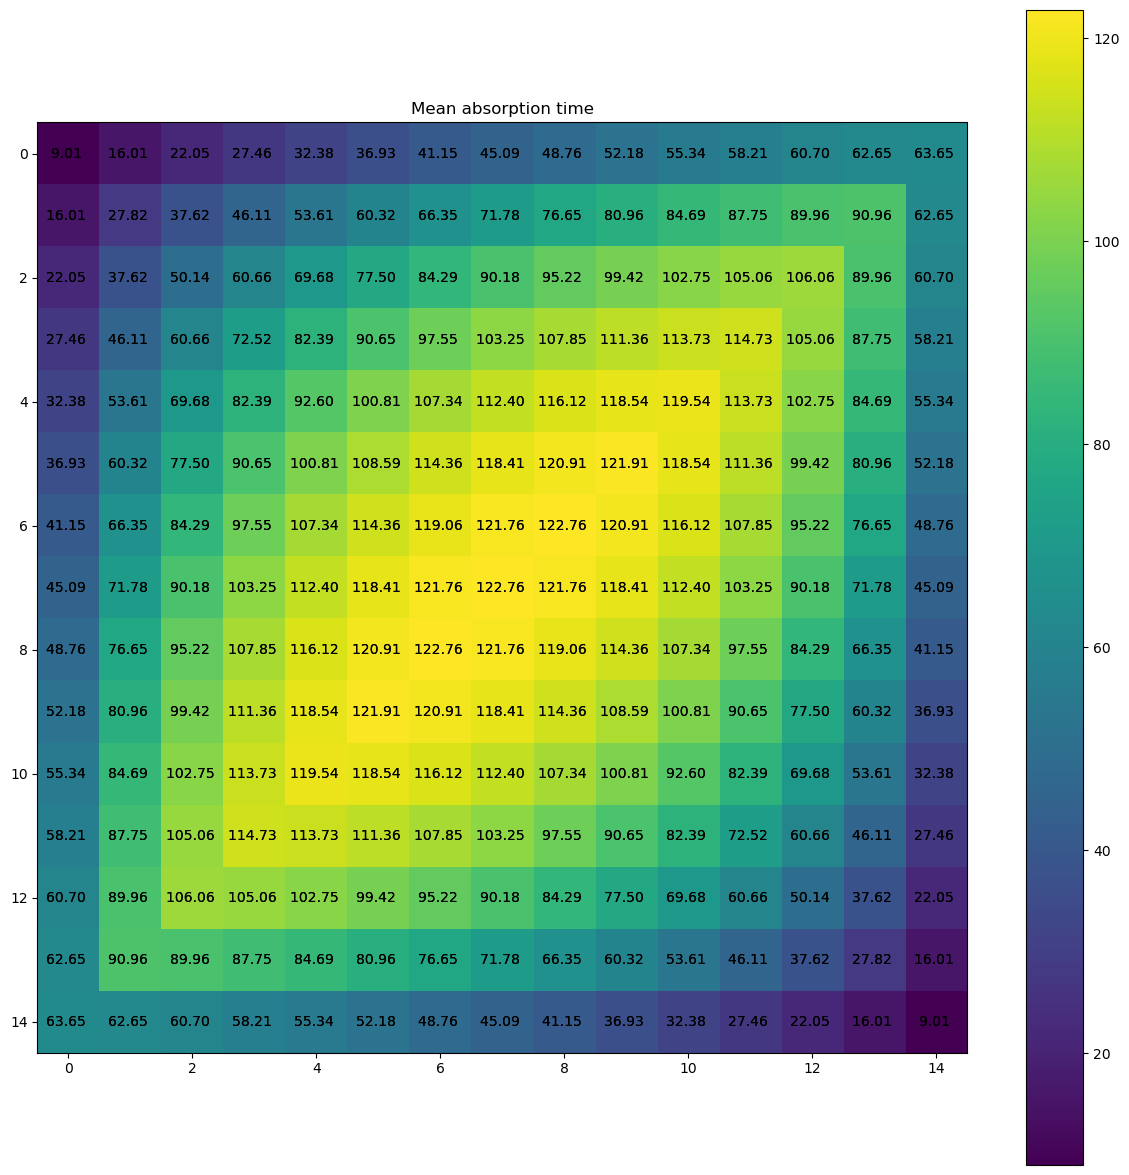

In [11]:
plt.figure(figsize=(15, 15))
plt.imshow(np.reshape(vs, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(np.reshape(vs, newshape=(inner_n, inner_n))):
    #print_str_1 = "↑→" if np.isclose(label, 1) else ""
    #print_str_2 = "↓←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} ", ha='center', va='center')
    plt.text(i, j, f"{label:.2f} ", ha='center', va='center')
    #print(label)
plt.title("Mean absorption time")

In [12]:
border_color_3 = np.array([204, 153, 255]) / 255.0
border_color_2 = np.array([178, 102, 255]) / 255.0
border_color_1 = np.array([141, 29, 255]) / 255.0
white_color = np.array([255, 255, 255]) / 255.0
center_color_1 = np.array([255, 202, 26]) / 255.0
center_color_2 = np.array([255, 219, 102]) / 255.0
center_color_3 = np.array([255, 231, 153]) / 255.0
rwgame_cmap = mcolors.LinearSegmentedColormap.from_list(
        'rwgame', [border_color_1, border_color_2, border_color_3, white_color, center_color_3, center_color_2, center_color_1])

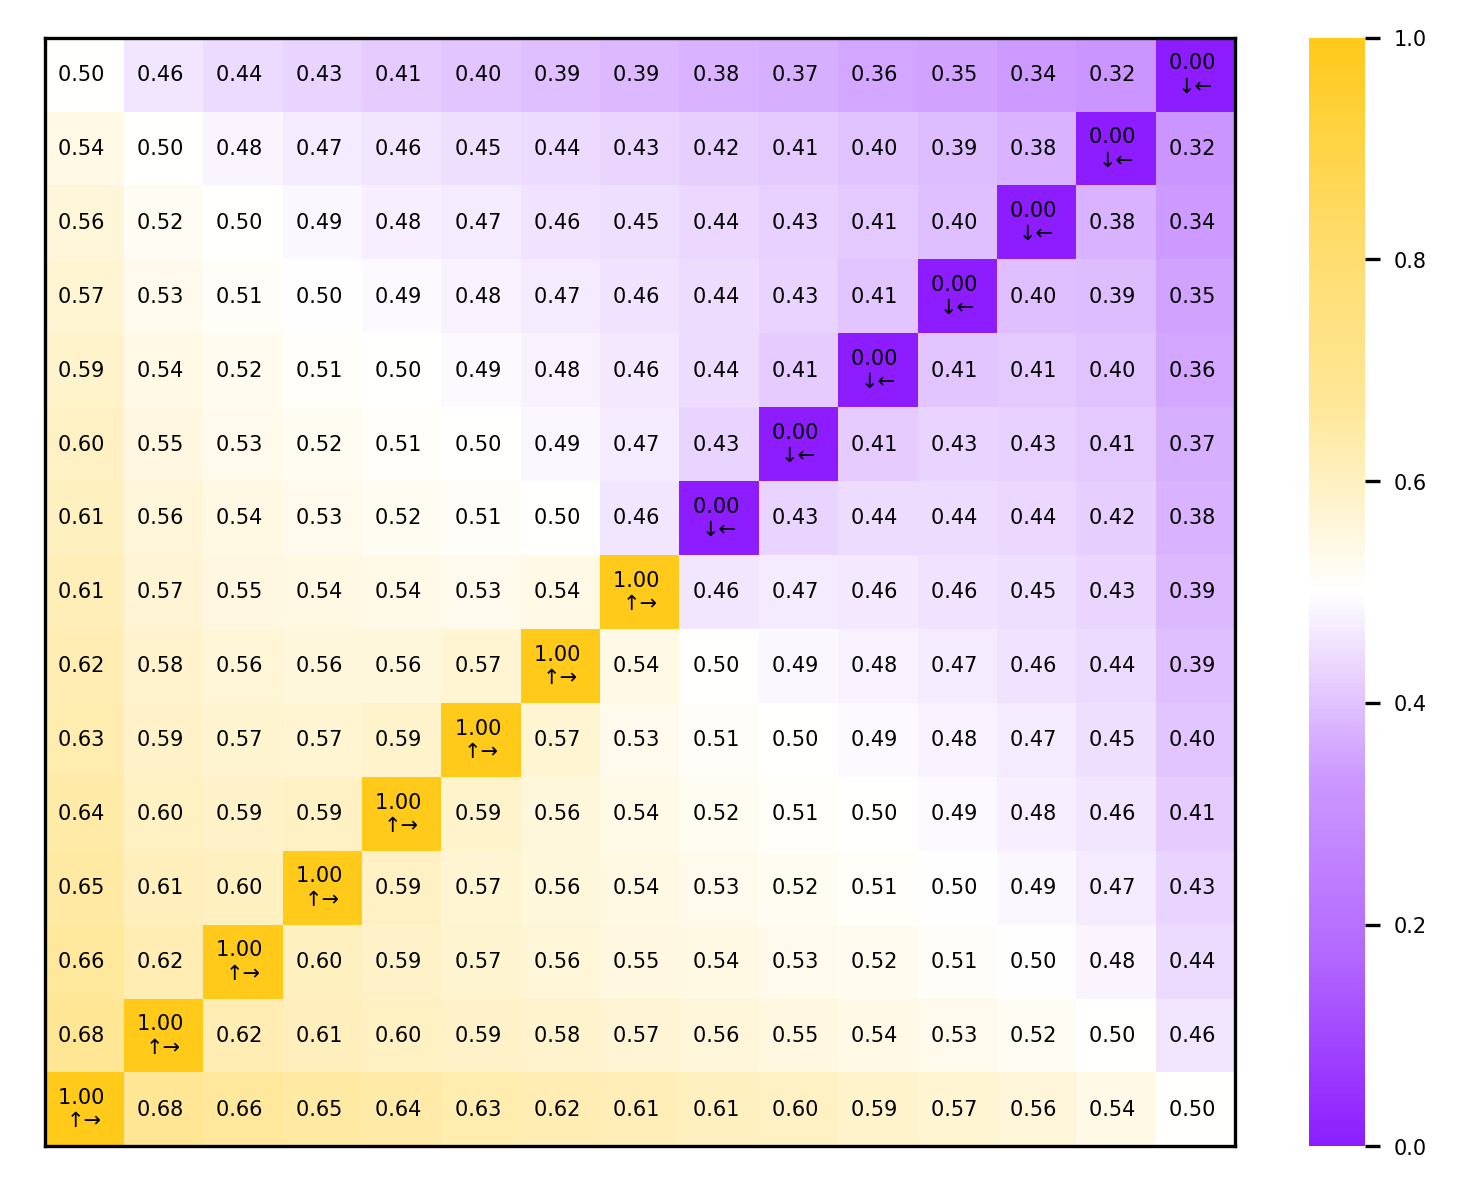

In [57]:
font = {'family' : 'normal',
        'size'   : 5}

mpl.rc('font', **font)

fig, ax = plt.subplots(1, 1, dpi=300)
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
a = sns.heatmap(np.reshape(p1s, newshape=(inner_n, inner_n)), cmap=rwgame_cmap, vmin=0, vmax=1)

for _, spine in ax.spines.items():
    spine.set_visible(True)

for (j, i), label in np.ndenumerate(np.reshape(p1s, newshape=(inner_n, inner_n))):
    print_str_1 = "\n↑→" if np.isclose(label, 1) else ""
    print_str_2 = "\n↓←" if np.isclose(label, 0) else ""
    plt.text(i+0.5, j+0.5, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')

#ax.set_title("Вероятность игрока \"за центр\" выбрать 1 стратегию.")
plt.savefig("G:\Studies\Masters\img\pvp_strategy.pdf", dpi=300)

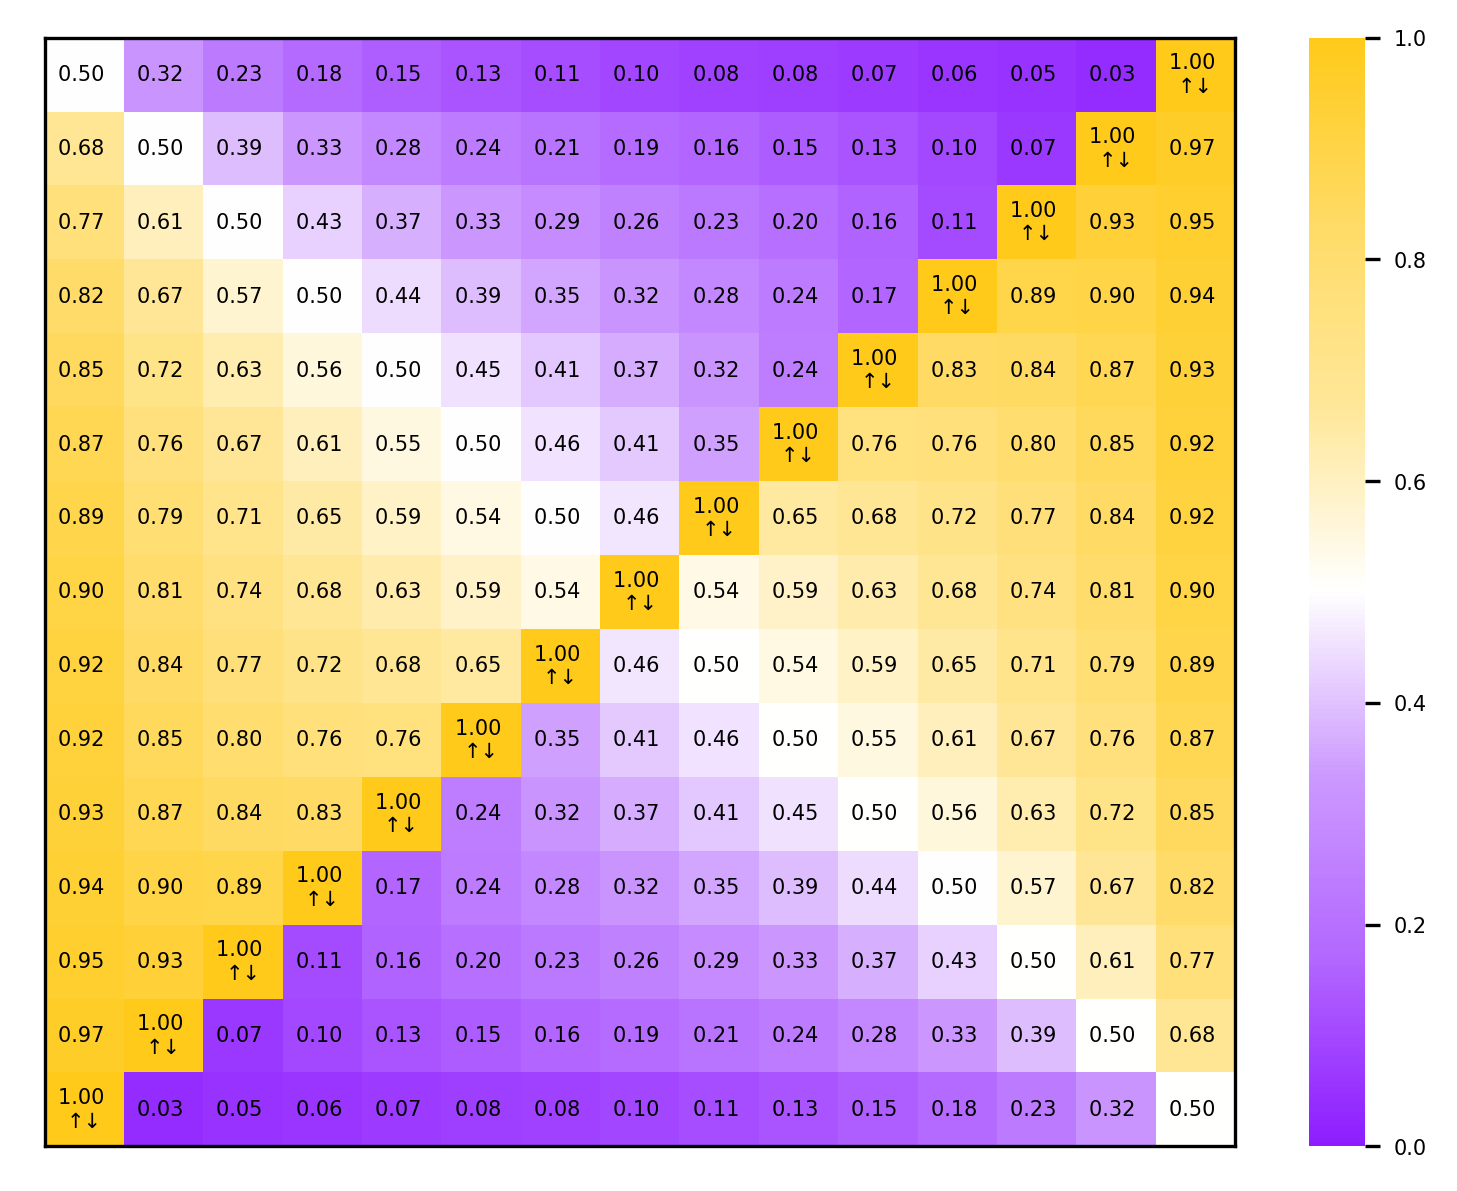

In [56]:
font = {'family' : 'normal',
        'size'   : 5}

mpl.rc('font', **font)

fig, ax = plt.subplots(1, 1, dpi=300)
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

a = sns.heatmap(np.reshape(q1s, newshape=(inner_n, inner_n)), cmap=rwgame_cmap, vmin=0, vmax=1)

for _, spine in ax.spines.items():
    spine.set_visible(True)

for (j, i), label in np.ndenumerate(np.reshape(q1s, newshape=(inner_n, inner_n))):
    print_str_1 = "\n↑↓" if np.isclose(label, 1) else ""
    print_str_2 = "\n→←" if np.isclose(label, 0) else ""
    plt.text(i+0.5, j+0.5, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')

font = {'family' : 'normal',
        'size'   : 8}
mpl.rc('font', **font)

cbar_vals = np.arange(0, 1.2, 0.2)
#ax.set_title("Вероятность игрока \"за границу\" выбрать 1 стратегию.")
plt.savefig("G:\Studies\Masters\img\pvp_2_strategy.pdf", dpi=300)
